In [33]:
import numpy as np
import random
import copy
import math
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from scipy.special import softmax
from tqdm import tqdm

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
class Game:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((4, 4), dtype=int)
        self.add_new_tile()
        self.add_new_tile()
        self.score = 0
        self.moves = 0
        return self.get_state()

    def add_new_tile(self):
        empty_cells = list(zip(*np.where(self.board == 0)))
        if empty_cells:
            x, y = empty_cells[np.random.choice(len(empty_cells))]
            self.board[x][y] = 2 if np.random.rand() < 0.9 else 4

    def get_state(self):
        state = [int(math.log2(max(square,1))) for square in self.board.flatten()]
        state = torch.LongTensor(state)
        state = F.one_hot(state, num_classes=16).float().flatten()
        state = state.reshape(1, 4, 4, 16).permute(0, 3, 1, 2)
        state = state.to(device)
        return state

    def combine(self, row):
        if len(row) < 2:
            return row
        else:
            if row[0] == row[1]:
                self.score += 2*row[0]
                return [2*row[0]]+self.combine(row[2:])
            else:
                return [row[0]]+self.combine(row[1:])

    def move_left(self):
        for i,row in enumerate(self.board):
            row = [x for x in row if not x==0]
            row = self.combine(row)
            row = row + [0]*(4-len(row))
            self.board[i] = row

    def rotate_cw(self, arr):
        return [list(x) for x in zip(*arr[::-1])]
            
    def move(self, direction):
        # 0-left, 1-down, 2-right, 3-up
        for _ in range(direction):
            self.board = np.array(self.rotate_cw(self.board))
        self.move_left()
        for _ in range((4-direction)%4):
            self.board = np.array(self.rotate_cw(self.board))

    def can_move(self, direction):
        old_board = copy.deepcopy(self.board)
        old_score = self.score
        self.move(direction)
        can = ~np.all(old_board == self.board)
        self.board = old_board
        self.score = old_score
        return can

    def push(self, direction):
        reward = 0
        done = False
        old_score = self.score
        old_board = self.board
        self.move(direction)
        if (self.board == old_board).all():
            reward += -10
        else:
            self.add_new_tile()
            done = self.is_over()
        reward += self.score - old_score
        new_state = self.get_state()
        self.moves += 1
        return new_state, reward, done
        
    def is_over(self):
        return all([~self.can_move(dir) for dir in range(4)])


In [30]:
class QNetwork(nn.Module):
    def __init__(self, input_shape):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[1], 2048, kernel_size=4, padding=0)
        self.conv2 = nn.Conv2d(input_shape[1], 1024, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(input_shape[1], 1024, kernel_size=1, padding=0)
        self.conv4 = nn.Conv2d(1024, 1024, kernel_size=4, padding=0)
        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=2, padding=0)


        self.fc1 = nn.Linear(2*2048, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 4)

    def forward(self, x):
        x.to(device)
        
        out_1 = torch.relu(self.conv1(x))
        out_2 = torch.relu(self.conv2(x))
        out_3 = torch.relu(self.conv3(x))
        out_4 = torch.relu(self.conv4(out_3))
        out_5 = torch.relu(self.conv5(out_2))

        x = torch.cat((out_1, out_4, out_5), dim=1)
        
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [31]:
class Event:
    def __init__(self, state, action, reward, next_state, done):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done

class DQNAgent:
    def __init__(self):
        self.q_network = QNetwork(input_shape=(1, 16, 4, 4)).to(device)
        self.target_network = QNetwork(input_shape=(1, 16, 4, 4)).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_network()
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.1

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append(Event(state, action, reward, next_state, done))

    def get_action(self, state):
        if random.random() < self.epsilon:  # Epsilon-greedy policy
            return torch.tensor([[random.choice(range(4))]], device=device, dtype=torch.long)
        with torch.no_grad():
            return self.q_network(state).argmax(1).view(1, 1)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        
        states = torch.cat([event.state for event in batch])
        actions = torch.cat([event.action for event in batch])
        rewards = torch.cat([event.reward for event in batch])
        next_states = torch.cat([event.next_state for event in batch if not event.done])
        not_dones = torch.tensor([not event.done for event in batch], device=device, dtype=torch.bool)

        expected_reward = self.q_network(states).gather(1, actions)

        next_state_values = torch.zeros(self.batch_size, device=device)
        next_state_values[not_dones] = self.target_network(next_states).max(1)[0].detach()
        actual_reward = (next_state_values * self.gamma) + rewards

        criterion = nn.MSELoss()
        loss = criterion(expected_reward, actual_reward.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

    def train(self, env, episodes):
        # self.generate_fixed_memory()
        scores = []
        for e in tqdm(range(episodes)):
            print('episode: ', e)
            state = env.reset()
            done = False
            while not done:
                action = self.get_action(state)
                next_state, reward, done = env.push(action)
                reward = torch.tensor([reward], device=device)
                self.remember(state, action, reward, next_state, done)
                state = next_state
            for _ in range(100):
                self.replay()
            scores.append(env.score)
            print('Epsilon:', self.epsilon)
            print('Score:', env.score)
            if e > 100:
                print('Last 100 Scores Avergae:', np.mean(scores[-100:]))
            self.update_target_network()
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                
        return scores

    def load(self, name):
        self.q_network.load_state_dict(torch.load(name))
        self.target_network.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.target_network.state_dict(), name)


In [46]:
if __name__ == "__main__":
    env = Game()
    agent = DQNAgent()
    agent.load("2048_dqn.pth")
    episodes = 5000  # Number of episodes to train

    scores = agent.train(env, episodes)
    agent.save("2048_dqn.pth")

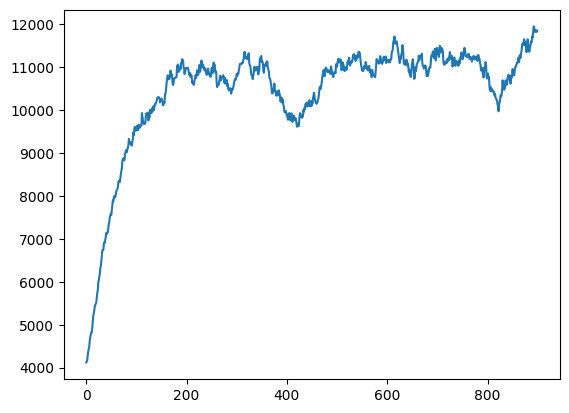

In [45]:
moving_avg_score = [np.mean(scores[i:i+100]) for i,_ in enumerate(scores[:-100])]
plt.plot(moving_avg_score)